In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functions.functions import EmissionProfile, AbsoluteMetricsPulseDefaultCO2, AbsoluteMetrics, RelativeMetrics
from climate_models.fair_emulator import BackgroundSpeciesQuantities, FaIRClimateModel, GWPStarEquivalentEmissionsFunction

C:\Users\t.planes\AppData\Local\miniconda3\envs\AeroMetrics\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Parameters

In [2]:
co2_method = 'FaIR' # IPCC or FaIR
start_year = 1765
t0 = 2020

## Metrics calculation

In [3]:
j = 0
time_horizon_range = range(20,160,10)
gwp_rf = np.zeros((len(time_horizon_range),4))
gwp_erf = np.zeros((len(time_horizon_range),4))
egwp_rf = np.zeros((len(time_horizon_range),4))
egwp_erf = np.zeros((len(time_horizon_range),4))
gtp = np.zeros((len(time_horizon_range),4))
ratr = np.zeros((len(time_horizon_range),4))

for studied_species in ["Aviation contrails", "Aviation H2O", "Aviation soot", "Aviation sulfur"]:
    
    if studied_species == "Aviation CO2":
        sensitivity_erf = 0 # Not used
        ratio_erf_rf = 1
        efficacy_rf = 1
        efficacy_erf = 1
        unit_value = 1*10**10
    elif studied_species == "Aviation contrails":
        sensitivity_erf = 9.36e-13
        ratio_erf_rf = 0.55 # 0.42
        efficacy_rf = 0.208
        efficacy_erf = 0.38
        unit_value = 1*10**10
    elif studied_species == "Aviation NOx":
        sensitivity_erf = [34.4e-12 * (14/46), -9.3e-12 * (14/46), -18.7e-12 * (14/46), -2.8e-12 * (14/46)]
        ratio_erf_rf = [1.37, 1.18, 1.18, 1.18]
        efficacy_rf = 1.0
        efficacy_erf = 1.0
        unit_value = 1*10**8
    elif studied_species == "Aviation H2O":
        sensitivity_erf = 0.0052e-12
        ratio_erf_rf = 1
        efficacy_rf = 1
        efficacy_erf = 1
        unit_value = 1*10**12
    elif studied_species == "Aviation soot":
        sensitivity_erf = 100.7e-12 # Not used
        ratio_erf_rf = 1
        efficacy_rf = 1
        efficacy_erf = 1
        unit_value = 1*10**14
    elif studied_species == "Aviation sulfur":
        sensitivity_erf = -19.9e-12 # Not used
        ratio_erf_rf = 1
        efficacy_rf = 1
        efficacy_erf = 1
        unit_value = 1*10**9
    
    unit_value_co2 = 1*10**10
    
    k = 0
    for time_horizon in time_horizon_range:
        end_year = t0 + time_horizon
        
        background_species_quantities = BackgroundSpeciesQuantities(start_year, end_year, rcp='RCP45')
        emission_profile_co2 = EmissionProfile(start_year,t0,time_horizon, 'pulse', unit_value_co2)
        emission_profile = EmissionProfile(start_year,t0,time_horizon, 'pulse', unit_value)
        
        if co2_method == 'IPCC':
            radiative_forcing_co2, agwp_co2, aegwp_co2, temperature_co2, agtp_co2, iagtp_co2, atr_co2 = AbsoluteMetricsPulseDefaultCO2(time_horizon, unit_value_co2)
        elif co2_method == 'FaIR':
            sensitivity_erf_co2 = 0 # Not used
            ratio_erf_rf_co2 = 1
            efficacy_rf_co2 = 1
            efficacy_erf_co2 = 1
            radiative_forcing_co2, effective_radiative_forcing_co2, temperature_co2 = FaIRClimateModel(start_year, end_year, background_species_quantities, emission_profile_co2, "Aviation CO2", sensitivity_erf_co2, ratio_erf_rf_co2)
            radiative_forcing_co2_unit, effective_radiative_forcing_co2_unit, temperature_co2_unit = radiative_forcing_co2/unit_value_co2, effective_radiative_forcing_co2/unit_value_co2, temperature_co2/unit_value_co2
            agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2 = AbsoluteMetrics(radiative_forcing_co2_unit, effective_radiative_forcing_co2_unit, efficacy_rf_co2, efficacy_erf_co2, temperature_co2_unit, time_horizon)
            
        radiative_forcing, effective_radiative_forcing, temperature = FaIRClimateModel(start_year, end_year, background_species_quantities, emission_profile, studied_species, sensitivity_erf, ratio_erf_rf)
        radiative_forcing_unit, effective_radiative_forcing_unit, temperature_unit = radiative_forcing/unit_value, effective_radiative_forcing/unit_value, temperature/unit_value
        agwp_rf, agwp_erf, aegwp_rf, aegwp_erf, agtp, iagtp, atr = AbsoluteMetrics(radiative_forcing_unit, effective_radiative_forcing_unit, efficacy_rf, efficacy_erf, temperature_unit, time_horizon)
        
        gwp_rf[k,j], gwp_erf[k,j], egwp_rf[k,j], egwp_erf[k,j], gtp[k,j], igtp, ratr[k,j] = RelativeMetrics(agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2, agwp_rf, agwp_erf, aegwp_rf, aegwp_erf, agtp, iagtp, atr)
        
        k += 1
        
    j += 1

Running 1 projections in parallel: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 405/405 [00:00<00:00, 2537.80timesteps/s]


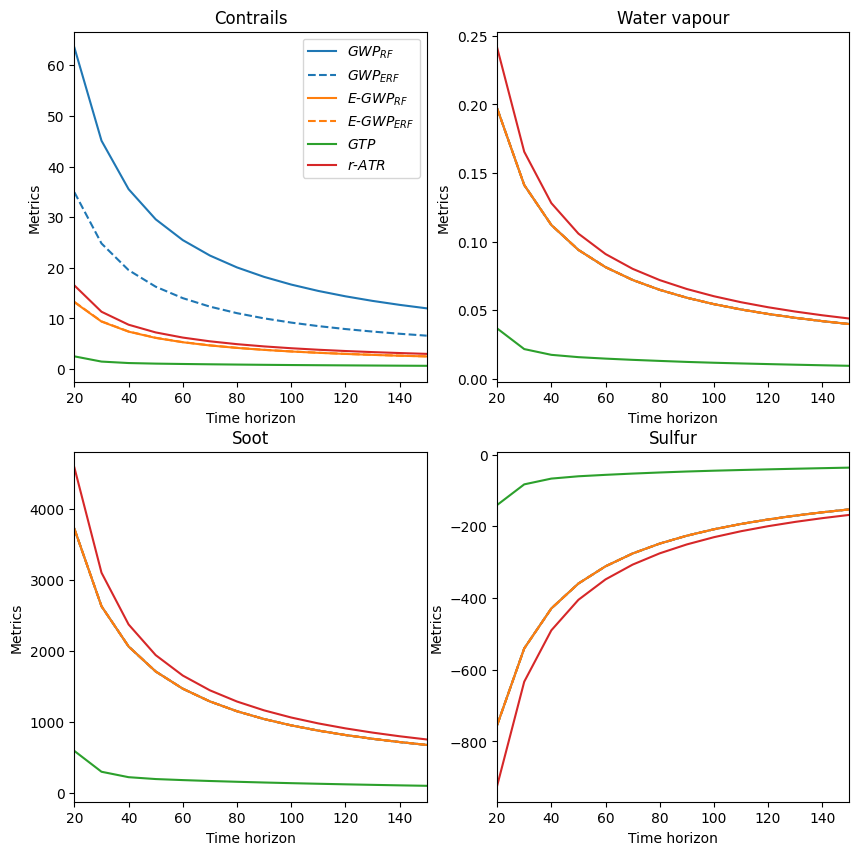

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
k = 0

for i, ax in enumerate(axes.flat):
    x_axis = time_horizon_range
    ax.plot(x_axis, gwp_rf[:, i], label=r'$GWP_{RF}$', color='C0')
    ax.plot(x_axis, gwp_erf[:, i], label=r'$GWP_{ERF}$', color='C0', linestyle='--')
    ax.plot(x_axis, egwp_rf[:, i], label=r'$E\text{-}GWP_{RF}$', color='C1')
    ax.plot(x_axis, egwp_erf[:, i], label=r'$E\text{-}GWP_{ERF}$', color='C1', linestyle='--')
    ax.plot(x_axis, gtp[:, i], label=r'$GTP$', color='C2')
    ax.plot(x_axis, ratr[:, i], label=r'$r\text{-}ATR$', color='C3')
    if k == 0:
        ax.legend()
    ax.set_xlim(min(time_horizon_range),max(time_horizon_range))
    ax.set_xlabel('Time horizon')
    ax.set_ylabel('Metrics')
    if i == 0:
        ax.set_title('Contrails')
    elif i == 1:
        ax.set_title('Water vapour')
    elif i == 2:
        ax.set_title('Soot')
    elif i == 3:
        ax.set_title('Sulfur')
    k=1
    
#plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()